In [ ]:
import re
import wget
file = open("/home/ubuntu/1000genomes.sequence.index")

In [ ]:
for line in file:
    #replace Telugu with what sample to download.
    if "Telugu" in line:
        link = re.search('ftp\S+.gz',line).group(0)
        wget.download(link)

# The files are already in hdfs, keeping the above code for the record

In [ ]:
# ls'ing our directory in hdfs, with the size of each file
import os

#.popen is a method for calling terminal commands inside python
f = os.popen('~/hadoop-2.7.7/bin/hdfs dfs -Dfs.defaultFS="hdfs://192.168.1.153:9000" -ls -h /team13')  
print(f.read())  

# Spark cluster connexion and configuration

In [1]:
from pyspark.sql import SparkSession
from operator import add

# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.1.131:7077") \
        .appName("Project_1320")\
        .config("spark.executor.cores",1)\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext

In [2]:
nucleotides = ('A', 'C', 'T', 'G', 'N')
kmer_length = 3

In [ ]:
pair_1 = spark_context.textFile("hdfs://192.168.1.153:9000//team13/ERR181393_1.fastq.gz")

In [ ]:
pair_2 = pair_1.zipWithIndex().filter(lambda x: x[1] > 0).map(lambda x: x[0])\
.filter(lambda x: all(nt in nucleotides for nt in list(x)))

In [ ]:
def kmer(line):
    counts = {}
    num_kmers = 100 - kmer_length + 1
    for i in range(num_kmers):
        kmer = line[i:i+kmer_length]
        if kmer not in counts:
            counts[kmer] = 0
        counts[kmer] += 1
    return counts.items()

In [ ]:
from operator import add
pair_3 = pair_2.flatMap(kmer)\
.reduceByKey(add)

In [ ]:
import time

start = time.perf_counter()
lsttpl = pair_3.collect()

with open('result.txt', 'w') as f:
    for tpl in lsttpl:
          f.write(' '.join(str(s) for s in t) + '\n')

NameError: name 'time' is not defined

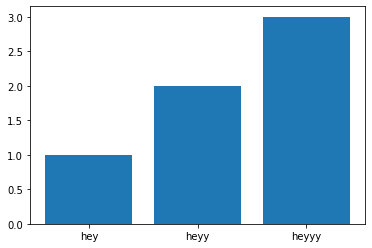

In [9]:
import matplotlib.pyplot as plt

with open('result.txt', 'w') as f:
    for item in lsttpl:
        f.write("%s\n" % item)
kmers = []
counts = []
for tpl in lsttpl:
    kmers.append(tpl[0]) 
    counts.append(int(tpl[1]))

plt.bar(kmers, counts, align = 'center')
end = time.perf_counter()
plt.xticks(kmers)
plt.ylabel('Kmer count')
plt.xlabel('Kmers')
plt.title('Kmer count in the human genome. Elapsed time: %.1f [min]' % ((end-start)/60))
plt.savefig('kmercount.png')

In [14]:
spark_context.stop()